In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst = QuantumInstance(qasm_sim, 2048)

In [3]:
fn = 'data_banknote_authentication.txt'
data = np.loadtxt(fn,dtype=float,delimiter=',')
x = data[:,:-1]
y = data[:,-1]
# We keep only a certain number of datapoints for each label
class_size = 200
x0 = x[data[:,-1] == 0][:class_size:]
x1 = x[data[:,-1] == 1][:class_size:]
labels = np.array([0]*class_size + [1]*class_size)
test_ratio= 0.2
seed = 3897
x_train, x_test, y_train, y_test = train_test_split(np.concatenate((x0, x1), axis=0), labels, test_size=test_ratio, random_state=seed, stratify=labels)
x_train = np.array([x/np.linalg.norm(x) for x in x_train]) 
x_test = np.array([x/np.linalg.norm(x) for x in x_test]) 

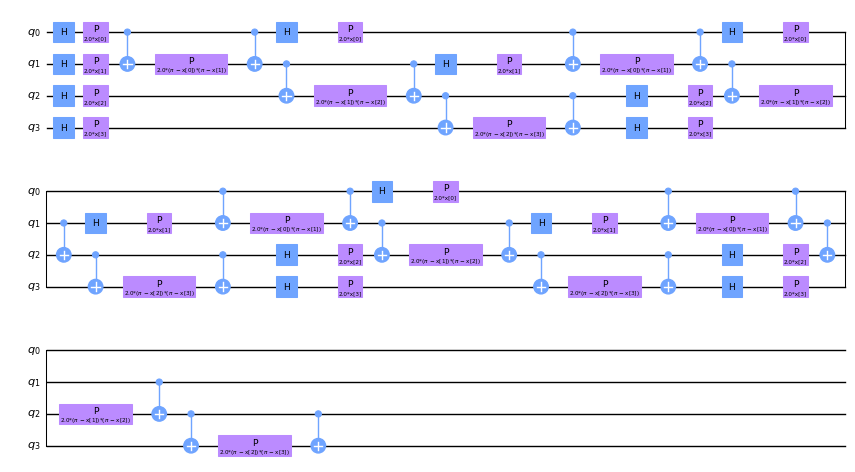

In [4]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(4, 4, 'linear')
fmap_zz.decompose().draw('mpl', scale=0.7)

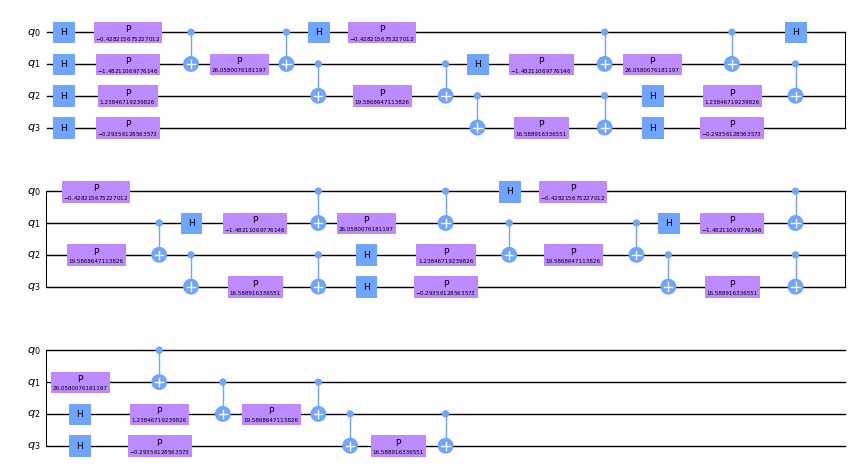

In [5]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train[0])}).decompose().draw('mpl', scale=0.7)

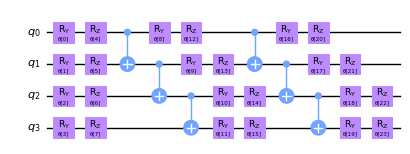

In [6]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(4, ['ry', 'rz'], 2, 'linear')
ansatz_tl.decompose().draw('mpl', scale=0.7)

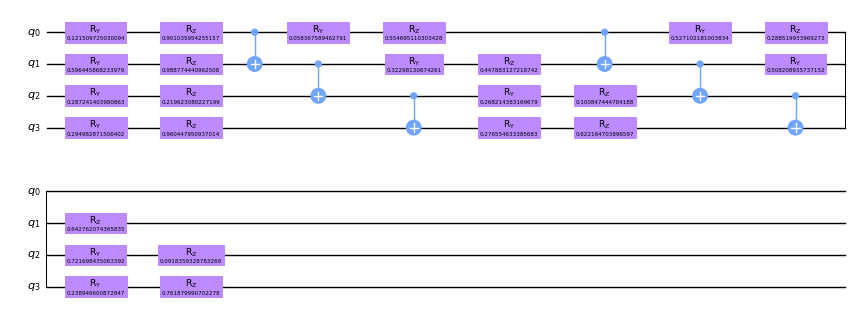

In [7]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

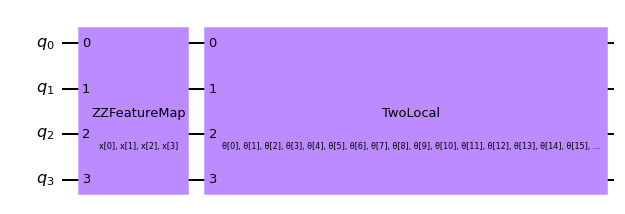

In [8]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [9]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [10]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [11]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.72509766, 0.27490234]])

In [12]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train[0], weights)
update

array([[[-2.23388672e-01, -5.12695313e-02,  4.71191406e-02,
         -8.30078125e-03,  3.66210938e-02,  6.83593750e-03,
         -1.17187500e-02, -3.46944695e-18, -5.81054687e-02,
         -9.76562500e-03, -1.51367187e-02, -5.12695313e-03,
          4.63867187e-02,  4.71191406e-02,  8.54492187e-03,
          9.76562500e-03, -3.85742188e-02,  7.81250000e-03,
         -1.78222656e-02, -2.44140625e-03,  4.88281250e-03,
         -3.17382812e-03,  3.90625000e-03, -4.88281250e-03],
        [ 2.23388672e-01,  5.12695312e-02, -4.71191406e-02,
          8.30078125e-03, -3.66210937e-02, -6.83593750e-03,
          1.17187500e-02, -1.64798730e-17,  5.81054688e-02,
          9.76562500e-03,  1.51367188e-02,  5.12695312e-03,
         -4.63867188e-02, -4.71191406e-02, -8.54492188e-03,
         -9.76562500e-03,  3.85742187e-02, -7.81250000e-03,
          1.78222656e-02,  2.44140625e-03, -4.88281250e-03,
          3.17382813e-03, -3.90625000e-03,  4.88281250e-03]]])

In [13]:
obs_parity = Z ^ 4
obs_one_qubit = I ^ (4 - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIZ'), coeff=1.0)

In [14]:
# For an introduction to the Opflow module, see
# https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap object at 0x00000194FFF49760>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [15]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(operator,
                   input_params=fmap_zz.parameters,
                   weight_params=ansatz_tl.parameters,
                   gradient=gradient,
                   quantum_instance=qinst)

In [16]:
output = op_qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 1)


array([[0.45996094]])

In [17]:
_, update = op_qnn.backward(x_train[0], weights)
print(update.shape)
update

(1, 1, 24)


array([[[-0.41601562, -0.12304688,  0.08056641, -0.00292969,
          0.05712891,  0.01123047, -0.01757812, -0.01855469,
         -0.12548828, -0.03759766, -0.01074219, -0.01660156,
          0.07226562,  0.0546875 , -0.01464844,  0.00976562,
         -0.10986328,  0.02978516,  0.02392578,  0.01513672,
         -0.01171875, -0.00634766, -0.0078125 , -0.02734375]]])

In [18]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [19]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [20]:
max_itr = 100
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


#x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train]) 

vqc = vqc.fit(x_train, y_train_1h)

3 - 368.3262916227431
6 - 342.80134751426596
9 - 341.38251587229826
12 - 328.9360311720735
15 - 328.6049247004553
18 - 326.6195991571079
21 - 322.3040024498975
24 - 320.5038806283484
27 - 320.0921891293501
30 - 315.4716676808982
33 - 309.0990250222222
36 - 307.2685285332446
39 - 306.72154126594916
42 - 307.1608645078246
45 - 305.8125266633763
48 - 306.0128725035749
51 - 306.24845036171365
54 - 304.8553677154414
57 - 305.88273251560344
60 - 305.6890672442273
63 - 303.62255755562296
66 - 304.7086416888038
69 - 303.0608203634729
72 - 303.2800915723149
75 - 302.38576563009576
78 - 302.3826820906303
81 - 301.6560473734562
84 - 301.483073986344
87 - 300.62809599944285
90 - 301.6691410488992
93 - 300.7482816076479
96 - 299.5220740116008
99 - 297.67477838134073
102 - 298.7499829740088
105 - 297.18830657611454
108 - 296.89213618118094
111 - 297.9123396788132
114 - 295.3915843355501
117 - 294.6836976455095
120 - 294.5430250069052
123 - 294.7291291936165
126 - 293.70092246540975
129 - 293.5584827

Score on the train set 0.665625
Score on the test set 0.6875


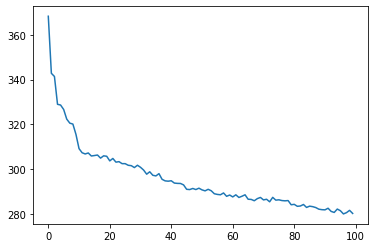

In [22]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')
plt.plot(loss_recorder)

# for class_size = 24 (10 iterations) Score on the train set 0.47368421052631576
# Score on the test set 0.7; wrong normalisation
# for class size = 100 (50 iterations) Score on the train set 0.46875
# Score on the test set 0.475; wrong normalisation
# by removing the normalisation line; class size = 100 Score on the train set 0.6
# Score on the test set 0.525
# Normalising from the beginning, Score on the train set 0.69375
# Score on the test set 0.575
# Increasing class_size to 200.  Score on the train set 0.64375
# Score on the test set 0.5625
# increasing maxiter to 100, class_size to 200, Score on the train set 0.690625
#Score on the test set 0.6875